In [1]:
%matplotlib inline
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
# pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 4))
pd.set_option('display.max_columns', None) #输出所有列

def set_ch():
    from pylab import mpl
    #中文字体问题已经解决，记录在evernote中
    #mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体
    mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
set_ch()
from datetime import datetime,timedelta
import matplotlib
matplotlib.style.use('ggplot')
import flatten_json
import re
import time
import math

In [2]:
import numpy
from scipy.io import wavfile
from scipy.fftpack import dct

In [3]:
sample_rate, signal =  wavfile.read('data/audio/si2217.wav')

In [4]:
len(signal)

42701

In [5]:
sample_rate

16000

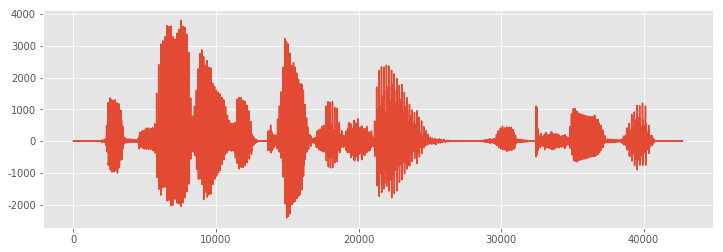

In [6]:
plt.plot(signal)

# pre_emphasis 预加重

* 目的 
为了消除发声过程中，声带和嘴唇造成的效应，来补偿语音信号受到发音系统所压抑的高频部分。并且能突显高频的共振峰。 
简单理解就是在频域上面都乘以一个系数，这个系数跟频率成正相关，所以高频的幅值会有所提升。实际上就是通过了一个高通滤波器 
$$ H(z)=1-kz^{-1} $$
* 实现 
$$ s_{n}^{'}=s_{n}−k∗s_{n−1} $$

In [7]:
pre_emphasis = 0.97
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

In [8]:
emphasized_signal

array([ 4.  , -1.88, -0.94, ..., -0.94,  3.03, -1.88])

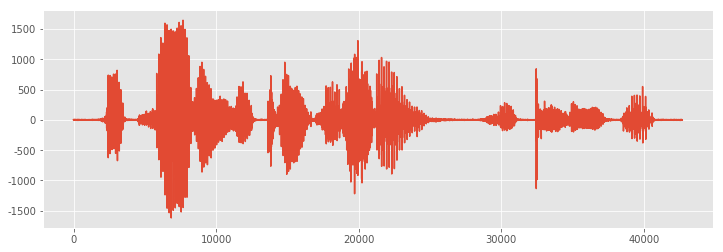

In [9]:
plt.plot(emphasized_signal)

# framing 分帧

先将N个采样点集合成一个观测单位，称为帧。通常情况下N的值为256或512，涵盖的时间约为20~30ms左右。为了避免相邻两帧的变化过大，因此会让两相邻帧之间有一段重叠区域，此重叠区域包含了M个取样点，通常M的值约为N的1/2或1/3。通常语音识别所采用语音信号的采样频率为8KHz或16KHz，以8KHz来说，若帧长度为256个采样点，则对应的时间长度是256/8000×1000=32ms

语音信号一般在10ms到30ms之间，我们可以把它看成是平稳的

In [10]:
frame_size = 0.025
frame_stride = 0.01

frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frams = int(numpy.ceil(float(numpy.abs(signal_length-frame_length)) / frame_step))

In [11]:
# 填充信号以确保所有帧具有相同数量的样本，而不截断来自原始信号的任何样本
pad_signal_length = num_frams * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) 

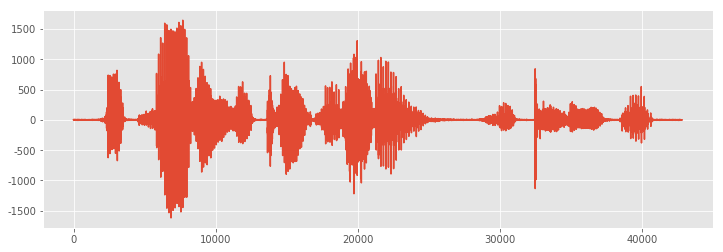

In [12]:
plt.plot(pad_signal)

In [13]:
indices = numpy.tile(numpy.arange(0, frame_length), (num_frams,1)) + numpy.tile(numpy.arange(0, num_frams*frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

# Hammin window 加窗

将每一帧乘以汉明窗，以增加帧左端和右端的连续性。假设分帧后的信号S(n), n=0,1…,N-1, N为帧的大小，那么乘上汉明窗后：
$$ s_{n}^{'} = s_n * w_n $$
其中：
$$ w_n=(1-a)−a*cos \frac{2πn}{N-1} , 0\leq n\leq N-1  $$
不同的a值会产生不同的汉明窗，一般情况下a取0.46

In [14]:
frames *= numpy.hamming(frame_length)

# Short-Time Fourier-Transform 快速傅里叶变换 & 功率谱

由于信号在时域上的变换通常很难看出信号的特性，所以通常将它转换为频域上的能量分布来观察，不同的能量分布，就能代表不同语音的特性。所以在乘上汉明窗后，每帧还必须再经过快速傅里叶变换以得到在频谱上的能量分布。对分帧加窗后的各帧信号进行快速傅里叶变换得到各帧的频谱。并对语音信号的频谱取模平方得到语音信号的功率谱。设语音信号的DFT为：
$$ \large X_a(k) = \sum_{n=0}^{N-1} x(n)e^{-\frac{j2\pi k}{N}} , 0\leq K\leq N $$
x(n)为输入的语音信号，N表示傅里叶变换的点数
功率谱（power spectrum）:
$$ \large P = \frac{|FFT(xi)|^{2}}{N} $$

In [15]:
NFFT = 512
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))

In [16]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2)) 

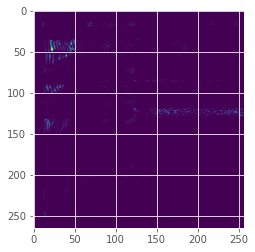

In [17]:
plt.rc('figure', figsize=(8,4))
plt.imshow(pow_frames)

# Filter Banks 滤波组——triangular filters三角带通滤波器

在mel刻度上通过三角形滤波器（通常为40个滤波器，n = 40）从功率谱提取频带。 mel刻度旨在模拟人类耳朵对对低频比有更高的识别性，对高频识别性较低的非线性感知。 可以使用下面的公式在赫兹（ff）和梅尔（mm）之间转换：
$$\large m=2595*log_{10}(1+\frac{f}{700}) $$
$$\large f=700*(10^{\frac{m}{2595}} - 1) $$

滤波器组中的每个滤波器都是三角形的，在中心频率处具有1的响应，并朝着0线性减小，直到达到响应为0的两个相邻滤波器的中心频率，如下图所示：<br>
  ![](filter bank on mel-scale.png)<br>
<br>
由以下公式实现:
H_m(k) =  
    \begin{cases}
      \hfill 0                                      \hfill & k < f(m - 1) \\
      \\
      \hfill \dfrac{k - f(m - 1)}{f(m) - f(m - 1)}  \hfill & f(m - 1) \leq k < f(m) \\
      \\
      \hfill 1                                      \hfill & k = f(m) \\
      \\
      \hfill \dfrac{f(m + 1) - k}{f(m + 1) - f(m)}  \hfill & f(m) < k \leq f(m + 1) \\
      \\
      \hfill 0                                      \hfill & k > f(m - 1) \\
  \end{cases}
  
* 目的 <br>
因为频域信号有很多冗余，滤波器组可以对频域的幅值进行精简，每一个频段用一个值来表示

In [18]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)
hz_points = (700 * (10**(mel_points/2595))-1)
bin = numpy.floor((NFFT+1) * hz_points/ sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m-1, k-21] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m-1, k-21] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

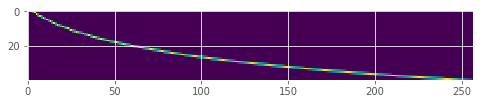

In [19]:
plt.imshow(fbank)

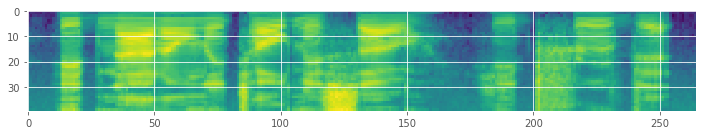

In [20]:
plt.rc('figure', figsize=(12,12))
plt.imshow(filter_banks.T)

In [21]:
filter_banks.shape

(265, 40)

# Discrete Cosine Transform(DCT)——离散余弦变换

In [22]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

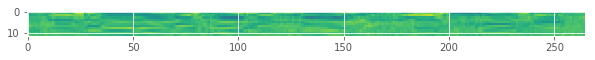

In [28]:
plt.rc('figure', figsize=(10, 10))
plt.imshow(mfcc.T)

In [29]:
mfcc

array([[-106.6832,  -40.8295,  -45.9647, ...,  -16.2262,   -4.8821,
           8.1181],
       [-105.9331,  -26.8942,  -34.7728, ...,  -20.7963,   -0.4885,
           5.5719],
       [ -92.9661,   -6.6607,  -32.5356, ...,  -19.1071,  -15.7902,
           5.8517],
       ..., 
       [-155.9442,   -1.5253,  -15.5508, ...,    3.0539,   -0.3326,
           3.4839],
       [-151.5395,   -1.3649,   -0.0212, ...,    7.2353,    6.3425,
           7.4504],
       [-142.7472,   -7.5324,   -6.2393, ...,   -2.575 ,  -11.3911,
          -9.8397]])

# use librosa to extract Spectral features

using in python3.5